In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import pickle
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [5]:
RANDOM_STATE = 42
pd.set_option('display.max_columns', None) 
h1 = pd.read_csv('C:/Users/guguc/Documents/H1.csv')
h1.head()


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
h1.shape

(40060, 31)

In [7]:
h2 = pd.read_csv('C:/Users/guguc/Documents/H2.csv')
h2.head()


(79330, 31)

In [8]:
h2.shape

(79330, 31)

In [9]:
# Adding a column to h1 to record that bookings belong to hotel 1:
h1['is_h1'] = 1

# Adding a column to h2 to record that bookings do not belong to hotel 1 (and therefore belong to hotel 2):
h2['is_h1'] = 0

In [10]:
# Combining the two datasets: 
df = pd.concat(objs = [h1, h2], axis = 0)

# Resetting the index
df.reset_index(drop = True, inplace=True)
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,is_h1
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,1


In [11]:
df.shape


(119390, 32)

In [12]:
# Creating a function to reformat the feature names:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()


In [13]:
# Reformating the feature names: 
df.columns = df.columns.map(camel_to_snake)

In [14]:
# Checking for missing data
df.isnull().sum()

is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                               0
company                             0
days_in_waiting_list                0
customer_type                       0
adr         

In [15]:
# Changing agent value of "NULL" to "No Agent":
df['agent'].replace(to_replace='NULL', value='No Agent', inplace=True)

# Changing company value of "NULL" to "No Company":
df['company'].replace(to_replace='NULL', value='No Company', inplace=True)

df.dropna(subset=['children'], inplace=True)

# Replacing null value for country feature with "unknown"
df['country'].fillna("unknown", inplace=True)

In [16]:
# Confirming that no missing values remain:
df.isnull().sum().sum()


0

In [17]:
# Checking our features' data types:
df.dtypes


is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                              object
company                           

In [19]:
# Changing children to integer type: 
df['children'] = df['children'].astype(int)

# Changing reservation status date to datetime type: 
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

In [20]:
# Checking for duplicates: 
df[df.duplicated(keep='first')]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1
5,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,1
22,0,72,2015,July,27,1,2,4,2,0,0,BB,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,250,NULL,0,Transient,84.67,0,1,Check-Out,2015-07-07,1
43,0,70,2015,July,27,2,2,3,2,0,0,HB,ROU,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient,137.00,0,1,Check-Out,2015-07-07,1
138,1,5,2015,July,28,5,1,0,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240,NULL,0,Transient,97.00,0,0,Canceled,2015-07-01,1
200,0,0,2015,July,28,7,0,1,1,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,109.80,0,3,Check-Out,2015-07-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,0,186,2017,August,35,31,0,3,2,0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,126.00,0,2,Check-Out,2017-09-03,0
119352,0,63,2017,August,35,31,0,3,3,0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0
119353,0,63,2017,August,35,31,0,3,3,0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0
119354,0,63,2017,August,35,31,0,3,3,0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0


In [21]:
# Creating the arrival date full feature: 
df['arrival_date_full'] = df['arrival_date_year'].astype(str) + "-" + df['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['arrival_date_day_of_month'].astype(str)
df['arrival_date_full'] = pd.to_datetime(df['arrival_date_full'], format="%Y-%m-%d")

In [22]:
# Creating a new feature representing length of stay or how many days before arrival did the customer cancel:
df['status_minus_arrival_date'] = np.abs(df['arrival_date_full'] - df['reservation_status_date']).astype(str)
# formating the feature 
def format_lenght(date):
    return date[0]
df['status_minus_arrival_date'] = df['status_minus_arrival_date'].map(format_lenght).astype(int)


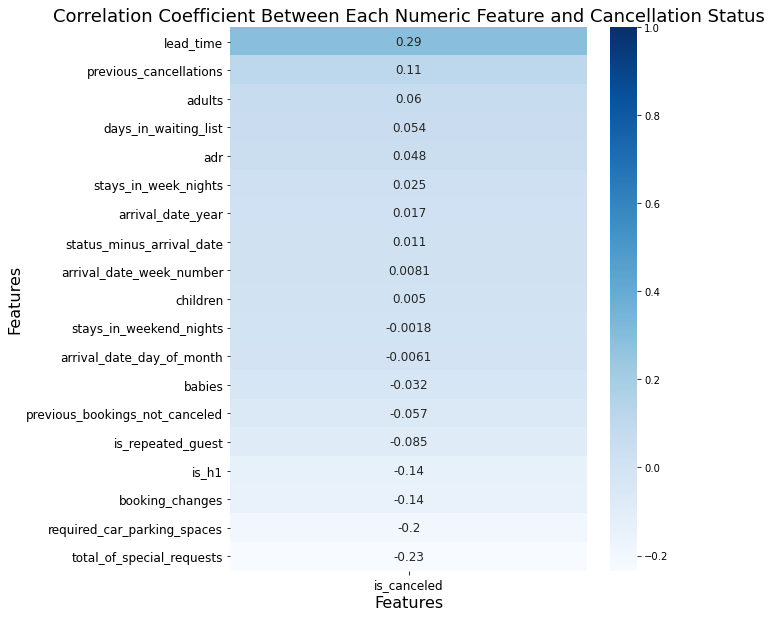

In [23]:
# Visualizing correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(df.corr()[['is_canceled']].sort_values('is_canceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Blues')
ax.set_title('Correlation Coefficient Between Each Numeric Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

In [24]:
df.groupby(df['deposit_type']).describe(include='all')
df.describe()

C:\Users\guguc\anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1629: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result = self.apply(lambda x: x.describe(**kwargs))
C:\Users\guguc\anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1629: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result = self.apply(lambda x: x.describe(**kwargs))
C:\Users\guguc\anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1629: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Speci

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_h1,status_minus_arrival_date
count,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000
mean,0.370395,104.014801,2016.156593,27.165003,15.798553,0.927605,2.500310,1.856390,0.103890,0.007949,0.031913,0.087121,0.137102,0.221131,2.321227,101.833541,0.062520,0.571340,0.335550,3.077270
std,0.482913,106.863286,0.707456,13.605334,8.780783,0.998618,1.908289,0.579261,0.398561,0.097438,0.175770,0.844350,1.497462,0.652315,17.595011,50.534664,0.245295,0.792798,0.472184,2.135633
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.590000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,1.000000,4.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,1.000000,9.000000


In [25]:
X = df.drop(columns=['is_canceled', 'reservation_status', 'agent', 'company', 'country', 'reservation_status_date', 'arrival_date_full'])
X.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_h1,status_minus_arrival_date
0,342,2015,July,27,1,0,0,2,0,0,BB,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,1,0
1,737,2015,July,27,1,0,0,2,0,0,BB,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,1,0
2,7,2015,July,27,1,0,1,1,0,0,BB,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,1,1
3,13,2015,July,27,1,0,1,1,0,0,BB,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,1,1
4,14,2015,July,27,1,0,2,2,0,0,BB,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,1,2


In [26]:
df = pd.get_dummies(df, columns=['arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type'])
X = df.drop(columns=['is_canceled','reservation_status', 'agent', 'company', 'country', 
                     'reservation_status_date', 'arrival_date_full'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y, test_size=0.15)


In [27]:
# Checking baseline model score 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print(f'Baseline Training Score: {dummy.score(X_train, y_train)}')
print(f'Baseline Testing Score: {dummy.score(X_test, y_test)}')

Baseline Training Score: 0.6296044462839236
Baseline Testing Score: 0.6296068796068796


In [28]:
#Logistic Regression
# Construct Grid Parameters
lg_params = {
    'penalty': ['l1'], 
    'C': [3.5],
    'max_iter': [300]
}
# Perform Grid Search
lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
                 lg_params,
                 cv = 5,
                 scoring = 'accuracy')
lg = lg_gs.fit(X_train, y_train)
# Scoring 
print(f'Best Training Accuracy: {lg.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

pickle.dump(lg, open('C:/Users/guguc/Documents/logreg.p', 'wb'))


Best Training Accuracy: 0.8119493880446993
Best Testing Accuracy: 0.8111458566004021
Cross-val-score: 0.8113849209953615


In [29]:
#decisiontree
# Construct Grid Parameters
dt_params = {
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25], 
    'min_samples_leaf': [1]
}

# Perform Grid Search
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')
dt = dt_gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {dt.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {dt.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(dt.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

pickle.dump(dt, open('C:/Users/guguc/Documents/dtree.p', 'wb'))


Best Training Accuracy: 0.9619621987031672
Best Testing Accuracy: 0.9415345097163279
Cross-val-score: 0.9373628676994444


In [31]:
#randomforest
# Construct Grid Parameters
rf_params = {
    'n_estimators': [150],  
    'max_features': [50],
    'max_depth': [13]
}

# Perform Grid Search
rf_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                 rf_params,
                 cv = 5,
                 scoring = 'accuracy')
rf = rf_gs.fit(X_train, y_train)

# Scoring 
print(f'Best Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {rf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rf.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9227615837915607
Best Testing Accuracy: 0.9198682153227608
Cross-val-score: 0.9195885523296564


In [32]:
# Creating a dataframe to compare our models' performances:
predictive_model_scores = pd.DataFrame(data=[('Baseline',0.62960, 0.62961), ('Logistic Regression',0.81271, 0.81181), 
                                             ('Decision Tree',0.96196, 0.94153), 
                                             ('Random Forest',0.92276,0.91987)],
                                       columns=['model', 'training_accuracy', 'testing_accuracy'])

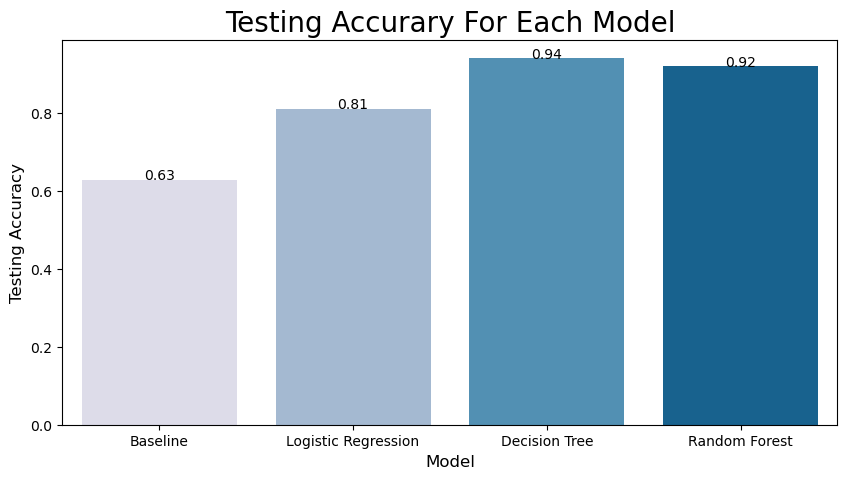

In [34]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='testing_accuracy', data=predictive_model_scores, palette='PuBu')
plt.title('Testing Accurary For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Testing Accuracy', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_accuracy, s=round(row.testing_accuracy,2), color='black', horizontalalignment='center');